## Imports y settings <br>

### Imports <br>

In [203]:
import pandas as pd
import numpy as np
import warnings
import re
import requests
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import reverse_geocoder as rg
import missingno as msno

<br>

<br>

#### Settings

In [204]:
# Seaborn style
sn.set_theme()


# Color palette for Plotly
palette = ["#FC645F", "#A8E4A0", "#7088FF", "#FEB1AF"]


# Silencing warnings
warnings.filterwarnings('ignore')


# Setting max columns to six
pd.options.display.max_columns = 15


# Setting max rows to ten
pd.options.display.max_rows = 10


# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Loading dataset
file = 'dataset.csv'
df = pd.read_csv(file)

<br>

<br>

### Funciones<br>

<b>table_dtype</b> <br>
<br>

In [205]:
def table_dtype(dataframe,rtn=True):
  # Función que crea reporte de tipo de variables y datos
  # dataframe = objet.dataframe
  # arg = True: use fig.show() otherwise it returns fig for object
  df_dtypes = dataframe.convert_dtypes()
  table_columns = [column for column in df_dtypes.dtypes.index.values]
  table_values = [str(value) for value in df_dtypes.dtypes]
  values = pd.Series(table_values)
  fig = make_subplots(rows=2,
                      cols=2,
                      specs=[[{"type":"table"},{"type":"domain"}],
                             [{"type":"table"},{"type":"domain"}]],
                      subplot_titles=["",
                                      "<b>TYPE",
                                      "",
                                      "<b>CLASS"])
  fig.add_trace(go.Pie(labels=values.value_counts().index,
                       values=values.value_counts(),
                       marker_colors=palette,
                       hole=0.4,
                       title=values.shape[0],
                       legendgroup="pie"),1,2)
  fig.update_traces(textposition='inside')
  fig.add_trace(go.Table(header=dict(values=['Column',
                                             'Data type'],
                                     fill_color="#A8E4A0",
                                     line_color='darkslategray'),
                         cells=dict(values=[table_columns,
                                            table_values],
                                    line_color='darkslategray')),1,1)
  fig.update_layout(height=500,width=1000,
                    title="<b>DATA TYPE ANALYSIS",
                    font_size=12)

  type_var = []
  for value in range(0,len(df_dtypes.dtypes)):
    if "Int"  in str(df_dtypes.dtypes[value]) or "Float" in str(df_dtypes.dtypes[value]):
      type_var.append("Numerical")
    else:
      if len(df_dtypes[df_dtypes.dtypes.index[value]].value_counts().index) <= 2:
        type_var.append("Numerical/Boolean")
      else:
        if len(df_dtypes[df_dtypes.dtypes.index[value]].value_counts().index) >= 100:
          type_var.append("Undetermined")
        else:
          type_var.append("Categorical")

  pie_values = [values for values in [type_var.count("Categorical"), type_var.count("Undetermined"), type_var.count("Numerical"), type_var.count("Numerical/Boolean")] if values !=0]
  pie_labels = str(set(type_var)).replace("{","").replace("}","").replace("'","").split(",")
  fig.add_trace(go.Table(header=dict(values=["Columns",
                                             "Classification"],
                                     fill_color="#A8E4A0",
                                     line_color='darkslategray'),
                         cells=dict(values=[df_dtypes.dtypes.index,type_var])),2,1)
  fig.add_trace(go.Pie(labels=pie_labels,
                       values=pie_values,
                       marker_colors=palette,
                       hole=0.4,
                       legendgroup="pie2"),2,2)
  fig.update_layout(height=800,width=1000,title="<b>DATA TYPE ANALYSIS",font_size=14)
  if rtn == True:
    fig.show()
  else:
    return fig

<br>

<b>historical_currency_data</b><br>
Esta función consume la API exchangerate.host para retornar datos relativa al tipo de cambio de una moneda en relación al dolar.<br>

In [206]:
def historical_currency_data(target_year, month_start, month_end, currency):
    exchg_series = []
    dates_series = []

    # Loop through month range for api consume
    for month in range(month_start,month_end+1):
        data = requests.get(f'https://api.exchangerate.host/{target_year}-{month}-15', params={'base':'USD', 'symbols':currency}).json()
        exchg_series.append(data['rates'][currency])
        dates_series.append(f'{target_year}-{month}-15')


    # We return the series in a readable dataframe format
    return pd.DataFrame({'index': [i for i in range(month_start, month_end+1)] ,'date': dates_series, 'rate':exchg_series}).set_index('index')

<br>

<b>viz_categorical</b> <br>
Esta función dinamicamente encuentra las variables catégoricas (con un value count de 25 o menos) de un dataframe y plotea los distintos valores en la serie. La utilizaremos para encontrar las variables categóricas sino tambien para marcar aquellas que son constantes, es decir, cuentan con un solo valor.<br>

In [207]:
def viz_categorical(dataframe):
    column_list = [column for column in dataframe.columns if len(dataframe[column].value_counts().index)>0 and len(dataframe[column].value_counts().index)<=40]
    context_dataframe = dataframe[column_list]
    
    
    # Calculating row index for plot based on x * 3 design
    if context_dataframe.shape[1] % 3 != 0:
        rows = round(context_dataframe.shape[1] / 3) + 1
    else:
        rows = round(context_dataframe.shape[1] / 3)


    # Plot constants
    fig, axes = plt.subplots(rows,3, figsize=(15, 10))
    fig.suptitle('Categorical variables')
    
    col_iter = 0
    row_iter = 0


    # Plotting
    for column, (i, ax) in zip(context_dataframe.columns, enumerate(fig.axes)):
        col_loc = context_dataframe.columns.get_loc(column)
        sn.barplot(x=context_dataframe[column].value_counts().index, y=context_dataframe[column].value_counts().values, ax=ax)
        ax.title.set_text(column)
        if len(context_dataframe[column].value_counts().index) > 5:
            ax.set_xticks([])

<br>

In [208]:


def dat_insights(dataframe,sheet_name=False,rtn=True,dat=False,date_parse=False):
  if type(dataframe) == str:
    dataframe = data_capture(dataframe,sheet_name,date_parse).capture()
  if dat is not False:
    dataframe = column_cleaner(dataframe,[column for column in dataframe.columns if column in dat])
  null_values = dataframe.isnull().sum().sort_values(ascending=False)
  nulls_sum = (dataframe.isnull().sum()).sum()
  fields_sum = (dataframe.shape[0] * dataframe.shape[1]) - nulls_sum
  nulls_percentile = max(null_values)
  fills_percentile = dataframe.shape[0] - nulls_percentile
  if null_values.shape[0] > 15:
    null_values = null_values[null_values != 0]
  else:
    pass
  fig = make_subplots(rows=2,
                      cols=2,
                      subplot_titles=["<b>CORRECT ENTRIES</b>",
                                      "<b>CORRECT CELLS",
                                      "<b>NULLS/COLUMN</b>"],
                      specs=[[{'type':'domain'},{'type':'domain'}],
                             [{'type':'xy',"colspan":2},{}]])
  fig.add_trace(go.Pie(labels=["Null entries","Valid entries"],
                       values=[nulls_percentile,fills_percentile],
                       hole=0.4,
                       marker_colors=palette,
                       name="Correct entries",
                       title=dataframe.shape[0],legendgroup="apie"),1,1)
  fig.add_trace(go.Pie(labels=["Null cells",
                               "Valid cells"],
                       values=[nulls_sum,
                               fields_sum],
                       hole=0.4,
                       marker_colors=palette,
                       name="Correct cells",
                       title=dataframe.shape[0]*dataframe.shape[1],
                       legendgroup="pie"),1,2)
  fig.add_trace(go.Bar(x=null_values,
                       y=null_values.index,
                       name="Nulls/Column",
                       orientation="h",
                       marker_color="#FC645F",
                       showlegend=False),2,1)
  fig.update_traces(textposition='inside')
  fig.update_layout(height=600,
                    width=800,
                    title=f"<b>{sheet_name.upper()} INSIGHTS</b>",
                    yaxis_title="Columns",
                    xaxis_title="Nulls",
                    font_size=14)
  if rtn == True:
    fig.show(config={'modeBarButtonsToAdd':['drawline',
                                            'drawopenpath',
                                            'drawclosedpath',
                                            'drawcircle',
                                            'drawrect',
                                            'eraseshape']})
  else:
    return fig





def correlation_matrix(dataframe, name, rtn=True):
  dataframe = dataframe.convert_dtypes()
  fig=make_subplots(cols=1,
                    rows=1)
  z,x = dataframe.corr(method="pearson"),dataframe.corr(method="pearson").columns
  fig.add_trace(go.Heatmap(z = z,
                           x = x,
                           y = x,
                           colorscale="Burg"))
  fig.update_layout(height=800,width=800,title=f"<b>{name} FEATURE CORRELATION MATRIX")
  if rtn == True:
    fig.show('png')
        # fig.show(config={'modeBarButtonsToAdd':['drawline',
        #                                     'drawopenpath',
        #                                     'drawclosedpath',
        #                                     'drawcircle',
        #                                     'drawrect',
        #                                     'eraseshape']})
  else:
    return fig

<br>

<br>

## Analisis de datos exploratorio<br>

### Primeros pasos <br>

Primero exportamos nuestro dataset como objecto pandas.dataframe para realizar las primeras observaciones. Observamos el número total de filas, columnas y la presencia de un elevado número de duplicados.
Con la utilización del método append, head y tail, generamos una preview del dataframe basada en los cinco primeros y últimos registros. <br>

In [209]:
print(f"El dataframe cuenta {df.shape[0]} filas, {df.shape[1]} columnas y un total de {df.duplicated().sum()} duplicados que representan un {round(df.duplicated().sum()/df.shape[0] * 100)}% del total de entradas")

El dataframe cuenta 121220 filas, 26 columnas y un total de 0 duplicados que representan un 0% del total de entradas


<br>

In [210]:
df_preview = pd.concat([df.head(5), df.tail(5)])
df_preview

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,...,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,...,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,...,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,...,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,...,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
121215,121215,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,...,NaN,NaN,10000.000,http://www.properati.com.ar/1cja2_venta_depart...,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,https://thumbs4.properati.com/1/bjms0KnaAnlNoQ...
121216,121216,sell,house,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,...,NaN,NaN,NaN,http://www.properati.com.ar/1cja6_venta_casa_b...,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,https://thumbs4.properati.com/2/PCc3WuQDjpNZc4...
121217,121217,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,...,NaN,NaN,NaN,http://www.properati.com.ar/1cja7_venta_depart...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...
121218,121218,sell,apartment,Plaza Colón,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,...,NaN,NaN,NaN,http://www.properati.com.ar/1cja8_venta_depart...,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,https://thumbs4.properati.com/8/Q12PTvU6BQJ0ib...
121219,121219,sell,apartment,Capital Federal,|Argentina|Capital Federal|,Argentina,Capital Federal,...,NaN,NaN,3500.000,http://www.properati.com.ar/1cjaa_venta_depart...,Departamento de 77 m2 apto profesional. Edific...,Departamento apto profesional en el Centro,https://thumbs4.properati.com/8/mNEsnQWqB7joBF...


<br> Con un pedido de atributo columns generamos una lista de todas las columnas presentes. <br>

In [211]:
df.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

<br>

<br>Al parecer contamos con dos columnas index debido a que el archivo csv incluía una columna de índice sin label. Esta columna es una primera candidata para ser eliminada, pero antes de proceder es necesario validar que efectivamente hay un match 1:1 entre ambas.
La validación mediante indexado booleano desmuestra que no parece haber ningún valor donde el índice del dataset no coincida con el índice genero al crear el dataframe, así que procedemos a su eliminación.<br>

In [212]:
df[df['Unnamed: 0'] != df.index]

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail


In [213]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

<br>

<br>Una observación rápida de las columnas properati_url e image_thumbnail parece indicar que se tratan de columnas relacionadas con la aplicación de donde fueron extraídos los datos. Dado que no cumplen ninguna función procedemos a eliminar ambas.<br>

In [214]:
df.drop(columns=['properati_url', 'image_thumbnail'], inplace=True)

<br>

<br>

### Control y eliminación de duplicados <br>

Auditamos la presencia de duplicados y procedemos a resolverlos.

In [215]:
# Realizamos un recuento de duplicidad
dataframer_shape = df.shape[0]
duplicates_count = df.duplicated().sum()


# Dropeamos los duplicados
df.drop_duplicates(inplace=True)


print(f'De un total de {duplicates_count}, {df.duplicated().sum()} no fueron resueltos. Los duplicados representaban un {round(duplicates_count / dataframer_shape * 100)}% de entradas del dataset.')

De un total de 5080, 0 no fueron resueltos. Los duplicados representaban un 4% de entradas del dataset.


<br>

<br>

### Tipo de datos y variables <br>

 Como es estandar en este tipo de procesos de limpieza, utilizamos el método dataframe.info para observar las columnas presentes, su conteo de no nulos y su tipo de datos. Sin embargo el formato tabla no permite análisis más profundo ni detalla si las columnas son categoricas o no. 

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116140 entries, 0 to 121219
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   operation                   116140 non-null  object 
 1   property_type               116140 non-null  object 
 2   place_name                  116117 non-null  object 
 3   place_with_parent_names     116140 non-null  object 
 4   country_name                116140 non-null  object 
 5   state_name                  116140 non-null  object 
 6   geonames_id                 97960 non-null   float64
 7   lat-lon                     67851 non-null   object 
 8   lat                         67851 non-null   float64
 9   lon                         67851 non-null   float64
 10  price                       98584 non-null   float64
 11  currency                    98583 non-null   object 
 12  price_aprox_local_currency  98584 non-null   float64
 13  price_aprox_us

<br>

Con esas limitaciones en mente, desarrollamos una función que utilizaremos de forma constante para controlar la evolución de nuestros datos durante el proceso de limpieza. En esta se eflejan los tipos de datos, su distribución y numero de columnas.

A partir de este pequeño dashboard observamos que: <br>
<li>Hay un total de 19 columnas.
<li>Sus tipos de datos (str, float e int) se encuentran balanceados. 
<li>La mayoría de las variables son de tipo númerica.
<li>Hay un número no despreciable de variables indeterminadas, probablemente producto de tener valores concatenados.
<li>Si bien observamos presencia de variables de tipo booleanas, estas solo fueron clasificadas como tal por tener un solo valor, es decir, por ser constantes.
</li> <br>

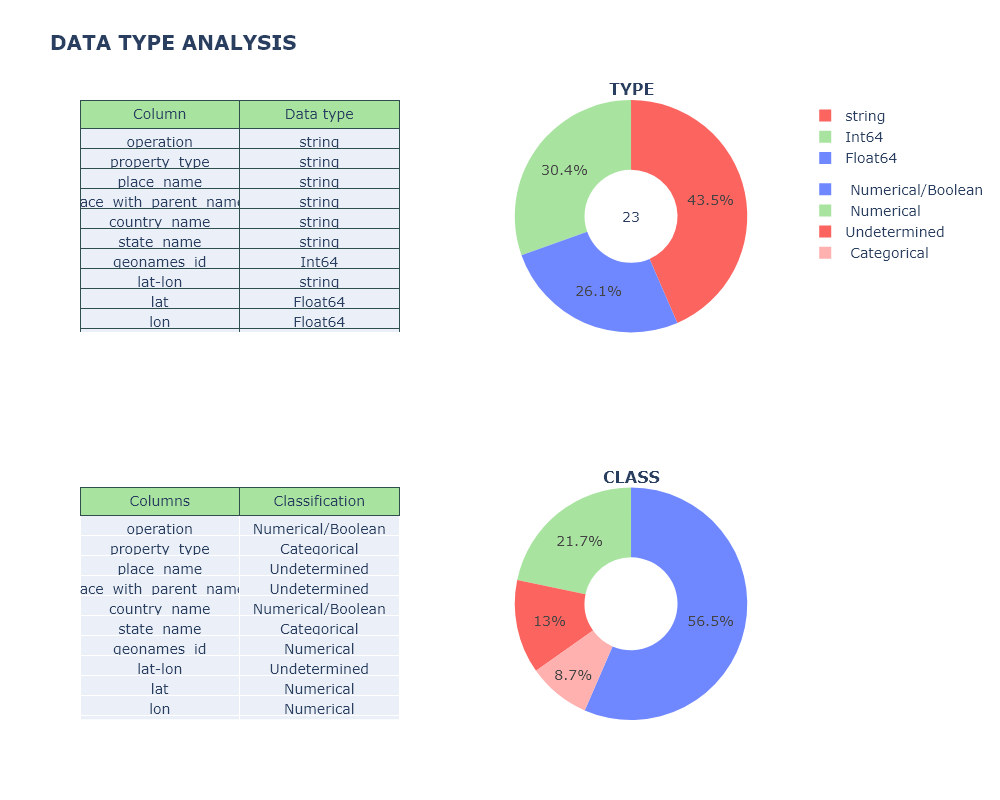

In [217]:
fig = table_dtype(df, rtn=False)
fig.show('png')

<br>

## Analisis de variables catégoricas <br>

Para reducir el length de nuestro dataset una de las primeras acciones que podemos tomar es encontrar variables categóricas y entre estas aquellas que sean constantes, es decir que no muestren ninguna variabilidad dentro de la serie.
Para esto utilizamos la función <i>viz_categorical</i> que comentamos en el apartado de funciones.

Observamos que:
<ul>
  <li>Contamos con un número reducido de variables categóricas.</li>
  <li>De estas, <i>operation</i> y <i>country_name</i> son constantes y deberan ser eliminadas dado que no tienen ningún valor predictivo sobre nuestra variable target </li>
  <li>La variable <i>property_type</i> se encuentra desbalanceada para algunas de las categorías. Una posible solución seria simplificar la clasificación en <i>apartment</i> y <i>other</i> en referencia a otro tipo de edificación</li>
  <li>Por otro lado, <i>currency</i> cuenta con outliers representados por PEN y UYU. Además ARS representa una porción muy baja de los registros. Lo mejor es realizar una conversión a USD de la variable precio para asegurar la consistencia y eliminar esta columna.</li>
</ul><br>

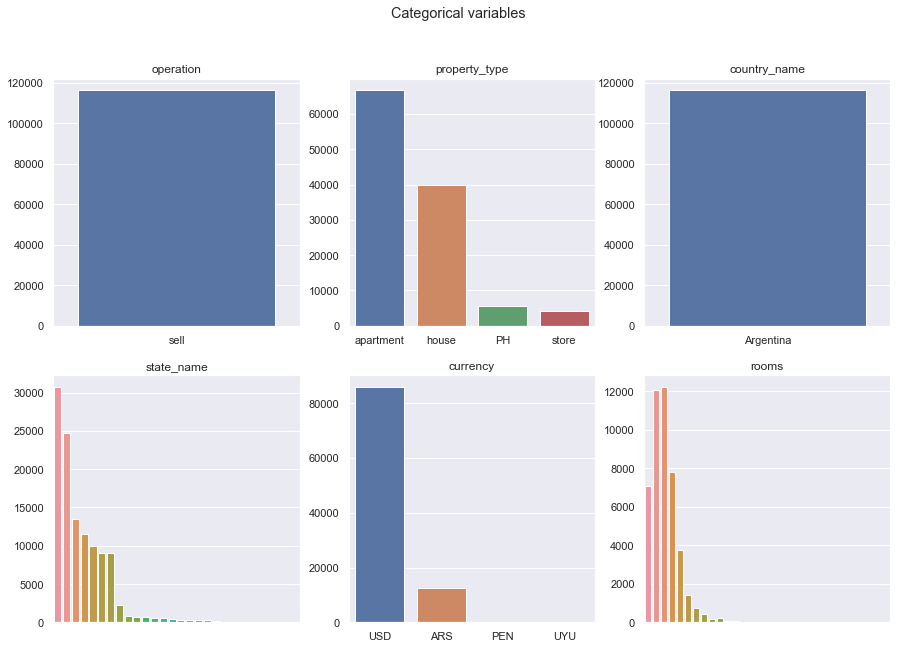

In [218]:
viz_categorical(df)

<br>

Para eliminar las constantes usaremos un one-liner / lambda function que representa la función a continuacion:

```python
def constant_check(dataframe):
    if isinstance(dataframe, pd.DataFrame) is True:
        for column in dataframe.columns:
            if len(dataframe[column].value_counts().index) == 1:
                dataframe = dataframe.drop(columns=[column])

    return dataframe
```

In [219]:
# Lambda function que realiza eliminación de series constantes
constant_check = lambda dataframe:  dataframe.drop(columns=[column for column in dataframe.columns if len(dataframe[column].value_counts().index) == 1]) if isinstance(dataframe, pd.DataFrame) is True else 'Not a dataframe'


# Realizamos la transformación
df = constant_check(df)

<br>

### Correcciones en price y currency

Como adelantabamos, podemos excluir del dataset la columna <i>currency</i> si convertimos el precio de las monedas ARS, UYU, PES a su correspondiente en USD. Además, la conversión es necesaria para reducir el ruido que estos valores generarán en el modelo. Para esto empleamos la función <b>historical_currency_data</b> para calcular el tipo de cambio promedio para cada una de las monedas durante 2018. <br>
En el dataframe de comprobación nos permite comparar que la conversación coincide con el valor aproximado para PEN, pero hay una notoria discrepancia para UYU y ARS, en este último caso debido a la depreciación del peso frente al dolar durante el trancurso de ese año.
<br>

In [220]:
def compare_currency_rates(year, month_s, month_e):
    
    # Con dict comprehension generamos un diccionario con los tipos de cambio promedios para cada moneda
    currency_dict = {currency:historical_currency_data(year,month_s,month_e,currency)['rate'].mean() for currency in df['currency'][(df['currency']!='USD') & (df['currency'].isna()==False)].value_counts().index.tolist()}


    # Creamos una máscara para filtrar USD y nulos del dataframe principal
    df_no_usd_and_null = (df['currency']!='USD') & (df['currency'].isna()==False)
    
    
    # Filtramos el dataframe para excluir nulos y los valores de price que corresponden a la moneda USD
    temp_df = df[df_no_usd_and_null]


    # Alteramos el dataframe original con la conversión correcta
    for currency, index, price in zip(temp_df['currency'], temp_df.index, temp_df['price']):
        temp_df['price'].loc[index] = price / currency_dict[currency]



    # Mascaras para el filtrado del dataframe de comprobación
    test_df_no_usd_and_null = (temp_df['currency']!='USD') & (temp_df['currency'].isna()==False)
    test_df_no_usd_ars_and_null = (temp_df['currency']!='USD') & (temp_df['currency']!='ARS') & (temp_df['currency'].isnull()==False)


    # Generamos el dataframe de comprobación
    temp_df = temp_df[['price', 'currency', 'price_aprox_usd']].convert_dtypes()



    return pd.concat([temp_df[test_df_no_usd_ars_and_null], temp_df[test_df_no_usd_and_null].head(3)])


compare_currency_rates(2018, 1, 12)

,price,currency,price_aprox_usd
50387,116081.176,PEN,117139.330
50388,290202.940,PEN,292848.330
107390,21689297.581,UYU,22980378.290
9,16696.628,ARS,25798.490
32,19963.359,ARS,30846.020
37,45371.271,ARS,70104.590


<br> Tomando los valores sólo el tipo de cambio medio de enero, obtenemos valores mas acordes para ARS pero con crecientes diferencias en relación a PES.

In [221]:
compare_currency_rates(2018, 1, 1)

,price,currency,price_aprox_usd
50387,120620.178,PEN,117139.330
50388,301550.445,PEN,292848.330
107390,23007449.564,UYU,22980378.290
9,24711.633,ARS,25798.490
32,29546.517,ARS,30846.020
37,67151.176,ARS,70104.590


<br> Realizando una breve comprobación de correlación de nulos entre ambas features y nos encontramos que la relación es 1:1. A partir de esto podemos decir con seguridad que es posible realizar un reemplazo de price como variable target por price_aprox_usd y esto mantendrá el modelo vigente a la fecha sin ser necesario generar conversiones ni conservar la columna currency.
<br>

In [222]:
df['price'].isna().sum(), df['price_aprox_usd'].isna().sum()

(17556, 17556)

<AxesSubplot:>

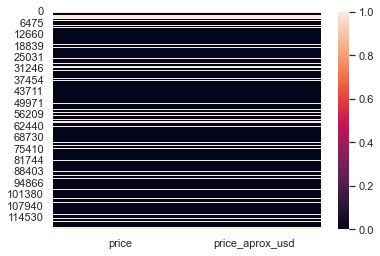

In [223]:
sn.heatmap(df[['price', 'price_aprox_usd']].isnull())


In [224]:
# Dropeamos las columnas mencionadas
df.drop(['price', 'currency'], axis=1, inplace=True)


# Renombramos price_aprox_usd a price_usd
df.rename({'price_aprox_usd':'price_usd'}, inplace=True, axis=1)

<br>

<br>

<br>

## Exploración de NaNs <br>

Otro paso importante de análisis es el recuento de nulos, su distribución y el proceso de imputarlos. Para esto ploteamos primero la suma de todos los camos nulos en relación a aquellos válidos. De este primer análisis se desprende que un 22% (400.000+) campos son nulos.

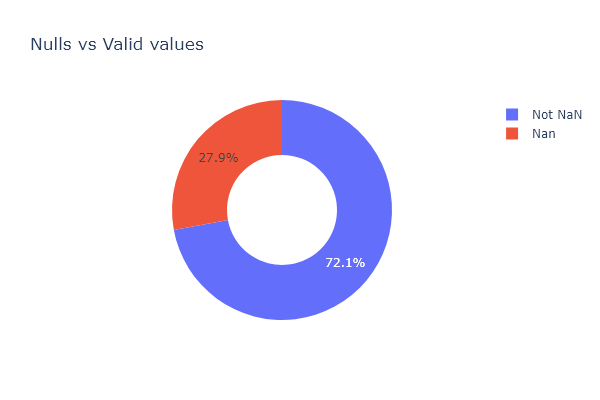

In [225]:
fig_pieplot = px.pie(
    labels=['NaN', 'Not NaN'],
    values=[df.isnull().sum().sum(), 
    df.shape[0]*df.shape[1]-df.isnull().sum().sum()], 
    width=600, height=400, 
    names=['Nan', 'Not NaN'], 
    title='Nulls vs Valid values', 
    hole=0.5)

fig_pieplot.show('png')

<br>

Luego ploteamos su distribución por columnas. De estas se destacan floor, rooms y expensas con el mayor recuento de nulos.

In [226]:
fig_barplot = px.bar(x=df.isna().sum().index, y=df.isna().sum().values,  width=600, height=400).update_xaxes(tickangle=45)
fig_barplot.show()

<br>

En la siguiente matriz se muestran las correlaciones de nulos entre las columnas, esto es, si los nulos de una columna se corresponden con los de otra. A partir de esta podemos inferir que:<br>

<li>Las columnas lat y lon presentan una correlación perfecta con la columna lat-lon, eso es debido a que si hay valores nulos en lat-lon encontramos tambien nulos en lat y en lon, probablemente como resultado de una operación split durante el proceso de ETL.

<li>Entre las columnas price_usd_per_m2 y surface_total_in_m2 y entre price_usd_per_m2 y surface_covered_in_m2 hay otra correlaciónn fuerte. Esto se debe a que, si hay nulos en las columnas de superficie, no se puede calcular el precio por metro cuadrado. 

<li>Tambien se ve una correlación moderada entre las columnas price_per_m2 y las columnas price_usd y price_aprox_local_currency, debido a que la falta de datos de precios impide los cálculos de otras columnas que dependen de ellos.
</li><br>

<AxesSubplot:>

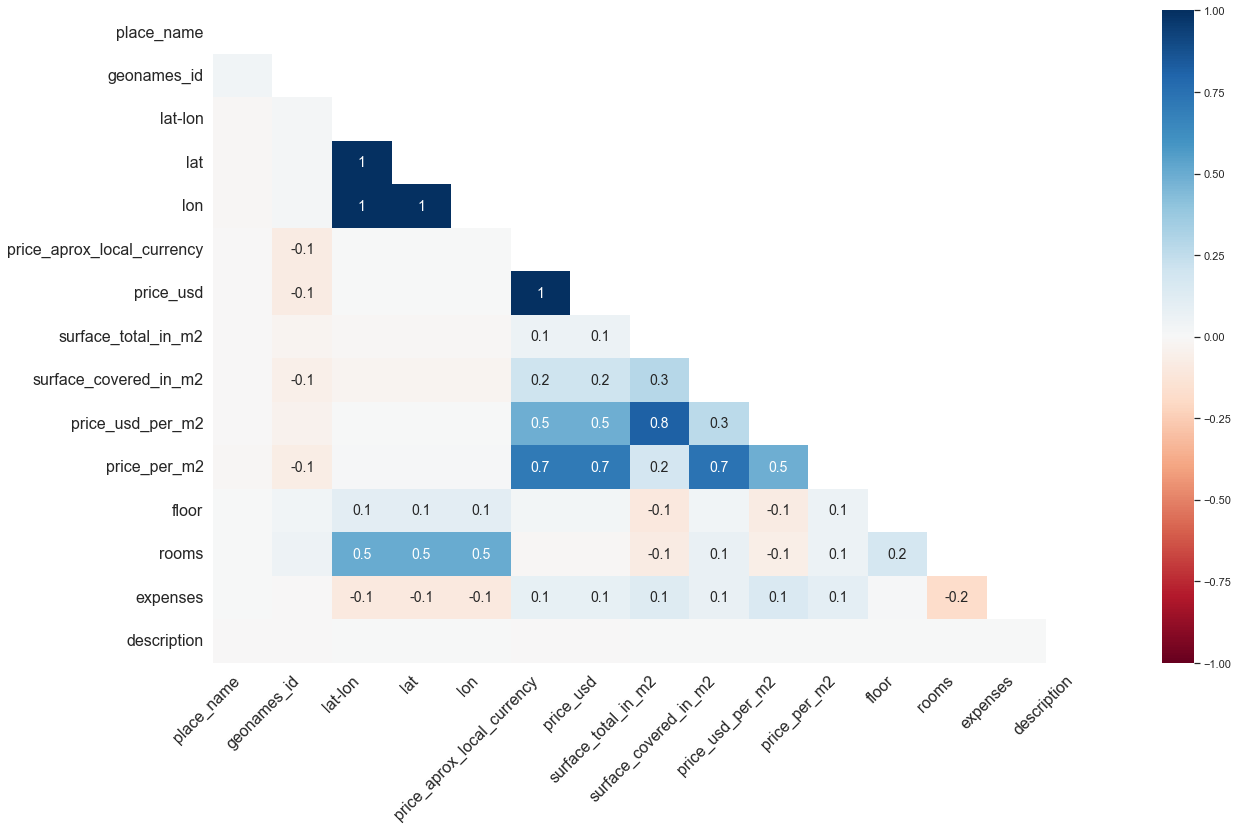

In [227]:
msno.heatmap(df)

<br>

Para simplificar el proceso de análisis y disminuir la repetición de código, creamos una función que nos permita repetir este proceso de inspección de forma sistemática y profunda en distintos momentos del proceso de limpieza que realizaremos. En nuestro pequeño dashboard se destaca además la diferenciación entre entradas y campos correctos.

In [228]:
x = dat_insights(df, "NaN analysis")

<br>

<br>

## Imputación de nulos

#### lat-lon, lat y lon <br>

Uno de los problemas que graficamos con anterioridad es la presencia de nulos en las columnas lat-lon, lat y long. Si bien no sabemos aun su importancia a nivel predictivo, podemos intentar rescartar alguno de los valores mediante el uso de la columna geonames_id, que se corresponde con los datos de la base de datos Geonames. Nuestra primera aproximación a este problema fue mediante el uso de la libreria Geocoder que emplea una API rest:
<br><br><br>

```python
import geocoder

def geocode_check(geocodeid):  

    lat = geocoder.geonames(geocodeid ,method='details', key='joaco').lat
    lon = geocoder.geonames(geocodeid ,method='details', key='joaco').lng

    result = f"{lat},{lon}"
    return result


df['geonames_id'].fillna(0, inplace=True)
df['lat-lon'] = df['geonames_id'].apply(lambda x: geocode_check(x) if x != 0 else None)
```


<br><br><br>Sin embargo, dado el volumne de nuestro dataset, superamos por completo el numero de consultas realizables. Debido a esto procedimos a descargar el dataset de la misma base de datos para realizar esta operación sin emplear la libreria Geocoder ni la API disponible.

In [229]:
# Variables de comprobación
before_lat_nulls = df['lat'].isnull().sum()
before_lon_nulls = df['lon'].isnull().sum()
before_com_nulls = df['lat-lon'].isnull().sum()
test = df[['lat-lon', 'lat', 'lon']]


# Cargamos el dataset y seteamos geonames_id como index
geonames = pd.read_csv('geonames.csv')
geonames = geonames.set_index('geonameid')


# Imputamos los NaN en geonames_id para evitar errores en el procesado
df['geonames_id'].fillna(0, inplace=True)


# Imputamos las columnas lat-lon
df['lon'] = df['geonames_id'].apply(lambda x: geonames['longitude'].loc[int(x)] if x in geonames.index else None)
df['lat'] = df['geonames_id'].apply(lambda x: geonames['latitude'].loc[int(x)] if x in geonames.index else None)


# Hacemos un update de lat-lon
def new_fun(x, y):
    if str(x) != 'nan' and str(y) != 'nan':
        return str(x) + ', ' + str(x)
    else:
        return None

df['lat-lon'] = df.apply(lambda x: new_fun(x['lat'], x['lon']) if new_fun(x['lat'], x['lon']) is not None else x['lat-lon'], axis=1)


# Results
rec_lat_nulls = before_lat_nulls-df['lat'].isnull().sum()
rec_lon_nulls = before_lon_nulls-df['lat'].isnull().sum()
rec_com_nulls = before_com_nulls-df['lat-lon'].isnull().sum()

print(f"""
Pudimos recuperar {rec_lat_nulls} latitudes ({int(rec_lat_nulls/df.shape[0]*100)}%)
Pudimos recuperar {rec_lon_nulls} longitudes ({int(rec_lon_nulls/df.shape[0]*100)}%)
Pudimos recuperar {rec_com_nulls} longitudes ({int(rec_com_nulls/df.shape[0]*100)}%)
 """)


Pudimos recuperar 29659 latitudes (25%)
Pudimos recuperar 29659 longitudes (25%)
Pudimos recuperar 40117 longitudes (34%)
 


<br> Finalmente ploteamos las diferencias y podemos observa que los resultados fueron favorables. Si bien no imputamos la totalidad, recuperamos una cantidad sustancial de datos.

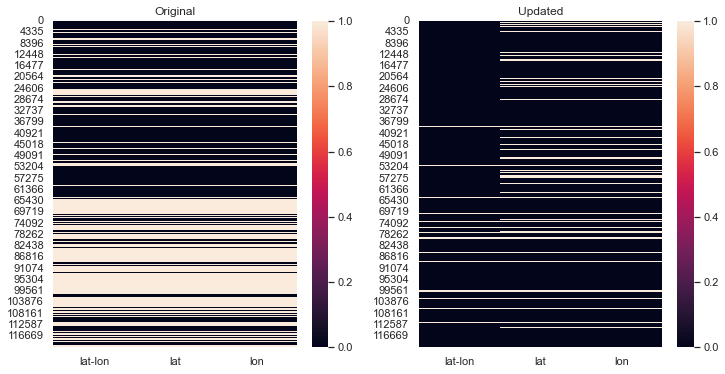

In [230]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
sn.heatmap(test.isna(), ax=axes[0])
sn.heatmap(df[['lat-lon', 'lat', 'lon']].isna(), ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Updated')
fig.show()

<br>

<br>

#### place_name <br>

A diferen del caso anterior, donde las columnas presentaban un número demasiado alto para el uso de una API duarante el proceso de imputación, place_name tiene un número de nulos bajo. Sin embargo, hay una relación 1:1 de nulos con la columna geonames_id que impide usar la libreria geocoder.

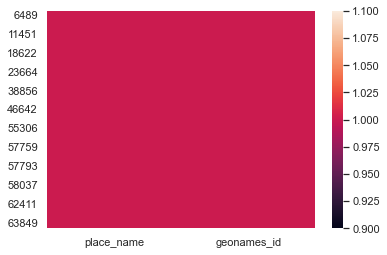

In [231]:
na_df = df[df['place_name'].isna()==True].loc[:, ['place_name', 'geonames_id']]
na_df['geonames_id'] = float('NaN')
new = sn.heatmap(na_df.isnull())

<br>

Para sortear la ausencia de geonames id empleamos reverse_geocoder que permite revetir la consulta empleando latitud y longitud. Dado que ya no usaremos la columna geonames_id, procedemos a eliminarla.

In [232]:
# Guardamos un registro para testear los resultados
check_entry = df.loc[6489]['place_name']


# Iteramos sobre los valores necesarios
for index, place_name, latlon in zip(df.index, df.place_name, df['lat-lon']):
    if str(place_name) == 'nan' :
        coordinates = tuple(latlon.split(','))
        df['place_name'].loc[index] = rg.search(coordinates)[0]['name']


print(f"El registro de la entrada de testeo era {check_entry} y su valor actual es {df.loc[6489]['place_name']}.")

El registro de la entrada de testeo era nan y su valor actual es Tigre.


In [233]:
df.drop('geonames_id', axis=1, inplace=True)

<br>

<br>

### Imputación mediante description y title

A través dedescription validaremos e imputaremos varias columnas, puesto que estas parecen ser una descomposición de la primera. Por este motivo, lo primero que haremos es descartar aquellos registros cuya descripción es nula.

In [234]:
df['description'].isnull().sum()

2

In [235]:
df.drop(index=df[df['description'].isnull() == True].index, inplace=True)
df[df['description'].isnull() == True].index

Int64Index([], dtype='int64')

#### Expenses

La cantidad de nulos en expenses es bastante alto, en muchos casos probablemente debido a la ausencia de estas y en otros por un ingreso de datos erroneo.

In [236]:
df['expenses'].isnull().sum()

102053

<br>

Efectivamente descubrimos que hay 1557 casos donde la propiedad no cuenta con expensas y que existe una categorización "bajas expensas".

In [237]:
# Generamos una expresión regular para contemplar casos sin expensas
expression_sin = re.compile(".*(no\spaga\sexpensas|sin\sexpensas)")


# Generamos una serie para contabilizar estos casos en el campo description
series_no_exp = df['description'].str.lower().apply(lambda x: 'sin expensas' if expression_sin.match(x) is not None else None)
series_no_exp.value_counts()

sin expensas    1611
Name: description, dtype: int64

In [238]:
expression_baj = re.compile(".*(?:bajas\s*expensas|bajisimas\s*expensas|expensas\s*bajas|bajisimas)")


# Generamos una serie para contabilizar estos casos en el campo description
series_ba_exp = df['description'].str.lower().apply(lambda x: 'bajas expensas' if expression_baj.match(x) is not None else None)
series_ba_exp.value_counts()

bajas expensas    2733
Name: description, dtype: int64

<br>

Mediante expresiones regulares podemos recuperar ademas aquellos casos donde la descripción incluye el valor de expensas.

In [239]:
# Creamos algunas funciones de limpieza que faciliten el trabajo con expresiones regulares y sus resultados
def convert(new_string):
    new_string = " ".join(new_string.split())
    remove_c = ['$', '.', ':', "'"]

    for character in remove_c:
        new_string = new_string.replace(character, '')

    return new_string


def clean_up(expenses_value):
    replace_list = ['mensuales', 'expensas', 'de']

    for replace_value in replace_list:
        expenses_value = expenses_value.replace(replace_value, '')

    return int(expenses_value)


# Generamos una expresión regular que contemple y capture los valores monetarios para expensas
expression_val = re.compile(".*(expensas\s*mensuales\s*(\d{1,5})|expensas\s*de\s*(\d{1,5})|expensas\s*(\d{1,5})|expensas\s*mensuales\s*(\d{1,5}))")


# Analizamos los resultados
serie_val = df['description'].str.lower().apply(lambda x: clean_up(expression_val.match(convert(x)).group(1)) if expression_val.match(convert(x)) is not None else None)
serie_val.value_counts().sum()

4396

<br>

Profundizando sobre este último paso descubrimos ademas que incluso para aquellos casos donde el valor de expensas no es nulo en su origen difiere del valor presente en descripción. Si consideramos las descripciones como fuente de verdad debemos entonces aplicar el proceso no solo a nulos sino a valores existentes.

In [240]:
serie_val.loc[143], serie_val.loc[120935], df.loc[120935]['expenses'] == serie_val.loc[120935]

(1300.0, 2000.0, False)

In [241]:
# Usamos lower sobre description para simplificar el proceso
df['description'] = df['description'].str.lower()


# Aplicamos el proceso sobre nuevas columnas
df['sinexp'] = df['description'].apply(lambda x: 'sin expensas' if expression_sin.match(x) is not None else None)
df['bajexp'] = df['description'].apply(lambda x: 'expensas bajas' if expression_baj.match(x) is not None else None)
df['valexp'] = df['description'].apply(lambda x: clean_up(expression_val.match(convert(x)).group(1)) if expression_val.match(convert(x)) is not None else None)


# Actualizamos expensas en base a las nuevas columnas
df['expenses'].update(df['sinexp'])
df['expenses'].update(df['bajexp'])
df['expenses'].update(df['valexp'])
df.drop(['sinexp', 'valexp', 'bajexp'], axis=1, inplace=True)


# Creamos una nueva categoria
df['expenses'][df['expenses'].isna()==True] = 'no informa'


# Control del resultado
df['expenses'].isnull().sum()

0

<br>

Finalmente convertimos en categorías que luego podriamos ysar para generar nuevas features. Para esto filtramos los valores que ya existen en forma de categorías y observamos como se separan en cuartiles de acuerdo a su valor númerico. En base a esta nueva información realizamos una categorización acorde.

In [242]:
ignored_values = ['no informa', 'sin expensas', 'expensas bajas']
masked_df = df[df['expenses'].isin(ignored_values) == False]


# Realizamos una reconfiguración de tipo de datos
masked_df['expenses'] = masked_df['expenses'].astype(float)


# Aplicamos un indexado booleano
mean = masked_df['expenses'].mean()
std = masked_df['expenses'].std()
masked_df = masked_df[masked_df['expenses'] < mean + (std*3)]


# Realizamos un describe
masked_df.loc[:, ['expenses']].describe()

,expenses
count,16853.000
mean,3245.974
std,4739.637
min,0.000
25%,1000.000
50%,2000.000
75%,4000.000
max,230000.000


In [243]:
# Iniciamos una nueva columna
masked_df['dum_col'] = 0


# Categorizamos de manera similar a lo generado con expresiones regulares
masked_df['dum_col'][masked_df['expenses'] > 8000]= 'expensas muy altas'
masked_df['dum_col'][(masked_df['expenses'] >= 4000) & (masked_df['expenses'] <= 8000) ]= 'expensas altas'
masked_df['dum_col'][(masked_df['expenses'] >= 1000) & (masked_df['expenses'] < 4000) ]= 'expensas normales'
masked_df['dum_col'][masked_df['expenses'] < 1000]= 'expensas bajas'


# Analizamos los resultados
masked_df['dum_col'].value_counts()

expensas normales     8607
expensas bajas        3657
expensas altas        3348
expensas muy altas    1241
Name: dum_col, dtype: int64

<br>

Aplicamos los resultados en el dataframe

In [245]:
for index, value in zip(masked_df.index, masked_df['dum_col']):
    df['expenses'].loc[index] = value

<br>

Filtramos outliers en expensas

In [246]:
filtered_list = [element for element in df.expenses.unique() if isinstance(element, str)]
df = df[df['expenses'].isin(filtered_list)]
df['expenses'].value_counts()

no informa            95229
expensas normales      8607
expensas bajas         6129
expensas altas         3348
sin expensas           1574
expensas muy altas     1241
Name: expenses, dtype: int64

<br>

Al plotear media y desvio estandar para cada una de las categorías observamos que "expensas altas" y "no informa" ambas tiene un desvío elevado. Si bien la primera puede ser eliminada como outliers debido a su bajo número y sustancial alejamiento del resto de los grupos, "no informa" es un caso más complejo debido a que representa una porción sustancial del dataset.<br>

Se presentan dos caminos posibles:
<li> Eliminar la columna de categorización de expensas debido a los datos faltantes.
<li> Realizar un unstacking de los valores no informados en el resto de categorías realizando una inferencia basada en quantiles.
</li>

En un futuro sería posible correr el modelo sobre ambos datasets y analizar la performance, y por en consecuencia la precisión de la inferencia y utilidad de la categorización. <br> 

De momento procedemos a su elimiación y reservamos una copia para continuar el trabajo realizado.


In [367]:
# Agrupamos para calcular mean y std para cada nivel de expensas
expenses_mean_for_price = df.loc[:, ['expenses', 'price_usd']].groupby(['expenses']).agg(['mean', 'std'])


# Ploteamos 
fig = px.scatter_3d(expenses_mean_for_price, x=expenses_mean_for_price.index, y=expenses_mean_for_price['price_usd']['mean'].tolist(), z=expenses_mean_for_price['price_usd']['std'].tolist(), width=800, height=600)
fig.update_layout(scene = dict(
                    xaxis_title='',
                    yaxis_title='price mean',
                    zaxis_title='price dev'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()


# Devolvemos el dataframe agrupado
expenses_mean_for_price

price_usd           
                         mean        std
expenses                                
expensas altas     364591.194 229720.823
expensas bajas     147106.630 276446.362
expensas muy altas 716705.802 526869.387
expensas normales  162989.911 217651.058
no informa         245215.561 413726.630
sin expensas       160887.563 132006.771

In [369]:
# Realizamos la copia
expensas_wip = df


# Corregimos el df
df = df.drop(columns=['expenses'])

## Dormitorios

In [ ]:
df['description'].str.find('MONOAMBIENTE')[df['description'].str.find('MONOAMBIENTE')!= -1]

Series([], Name: description, dtype: int64)

In [ ]:
df['description'].str.find('monoambiente')[df['description'].str.find('monoambiente')!= -1]

7          10
45          8
66        271
74         25
100       149
         ... 
121136     10
121137     10
121152      0
121158     75
121217    109
Name: description, Length: 6921, dtype: int64

In [ ]:
df['description'].str.find('mono ambiente')[df['description'].str.find('mono ambiente')!= -1]

207       198
208       198
218       198
530        27
532        35
         ... 
119552     71
119743    107
119795    284
120018    403
120206    110
Name: description, Length: 660, dtype: int64

In [ ]:
df['description'].str.find('MONO AMBIENTE')[df['description'].str.find('MONO AMBIENTE')!= -1]

Series([], Name: description, dtype: int64)

In [ ]:
df['description'].str.find('dormitorio')[df['description'].str.find('dormitorio')!= -1]

0         181
1         210
2          97
4         146
5         167
         ... 
121212    309
121213    319
121215    157
121216    455
121218     99
Name: description, Length: 75515, dtype: int64

In [ ]:
df['description'].str.find('DORMITORIO')[df['description'].str.find('DORMITORIO')!= -1]

Series([], Name: description, dtype: int64)

## Otros

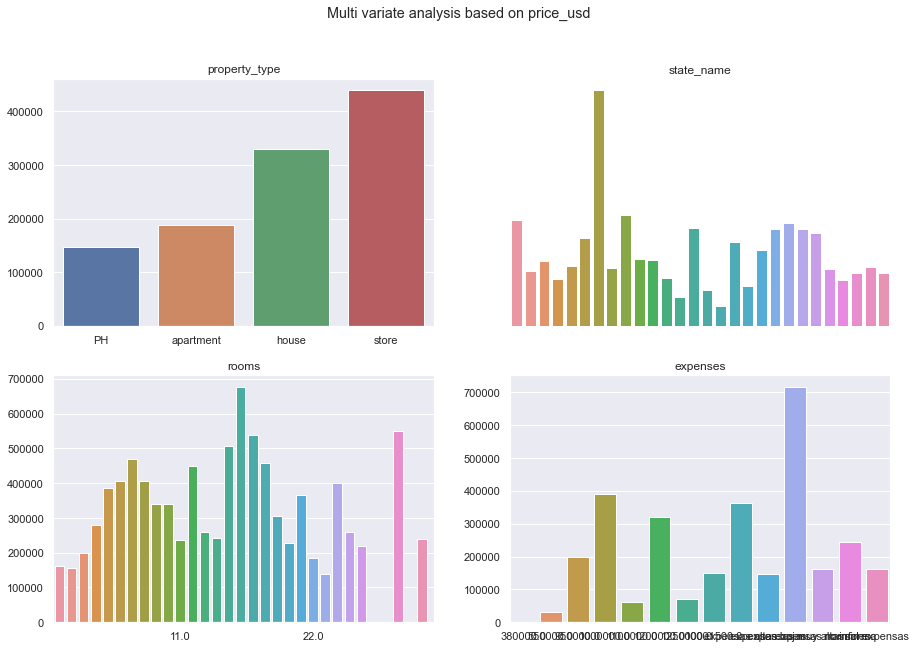

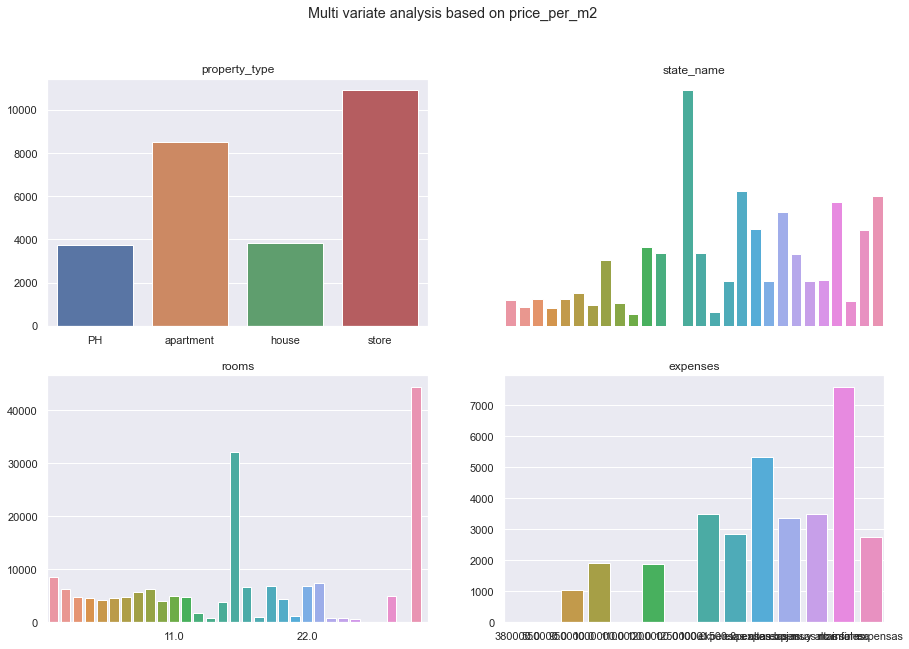

In [ ]:
targets = ['price_usd', 'price_per_m2']

def multi_variate_analysis(targets):
    columns = [column for column in df.columns if len(df[column].value_counts().index) > 1 and len(df[column].value_counts().index) < 50]

    if len(columns) % 2 == 0:
        rows = round(len(columns) / 2)
    else:
        rows = round(len(columns) / 2) + 1


    for target in targets:

        globals()['fig' + target], axes = plt.subplots(rows, 2, figsize=(15, 10))
        globals()['fig' + target].suptitle(f'Multi variate analysis based on {target}')


        for column, (i, ax) in zip(columns, enumerate(globals()['fig' + target].axes)):
            
            group_df = df[[column, target]].groupby(by=[column]).mean(target)
            sn.barplot(x=group_df.index.tolist(), y=group_df[target].tolist(), ax=ax)
            
            if df[column].dtype == 'float64':
                ax.set_xticks([round(len(df[column].value_counts().index)/3), round(len(df[column].value_counts().index)* (2/3)) , len(df[column].value_counts().index)])
            elif df[column].dtype == 'O' and len(df[column].value_counts().index) > 15:
                ax.set_axis_off()

            ax.set_title(column)

multi_variate_analysis(targets)

In [ ]:
from spa2num.converter import to_number


for description, rooms, index in zip(df['description'], df['rooms'], df.index):
    description = re.sub(' +', ' ', description.lower())
    temp_list = description.lower().split(' ')
    
    if 'monoambiente' in temp_list:
        rooms = 1
    elif 'mono' in temp_list:
        rooms = 1
    elif 'ambientes' in temp_list:
        rooms = temp_list[temp_list.index('ambientes') - 1]
    elif 'ambiente' in temp_list:
        rooms = temp_list[temp_list.index('ambiente') - 1]
    elif 'rooms' in temp_list:
        rooms = temp_list[temp_list.index('rooms') - 1]
        print(rooms,index)
 
    if isinstance(rooms, int) is True:
        df['rooms'].loc[index] = rooms
    elif isinstance(rooms, str) is True:
        try:
            rooms = to_number(rooms)
            if isinstance(rooms, int) is True:
                df['rooms'].loc[index] = rooms
        except:
            pass


ModuleNotFoundError: No module named 'spa2num'

In [ ]:
df['rooms'].isnull().sum()

53660

In [ ]:
temp_df = df[['rooms', 'description']]
temp_df = temp_df[temp_df['rooms'].isnull()==True]
temp_df = temp_df.loc[temp_df['description'].str.contains('ambiente')]


temp_df
# df.loc[df['description'].str.contains('room')]

,rooms,description
18,NaN,Casa sobre lote al golf en barrio San Isidro L...
22,NaN,Edificada en 2 plantas. PB. amplio living con ...
58,NaN,Magnífica residencia con calidad de construcci...
100,NaN,San Nicolás 365ENTREGA INMEDIATA.Edificio de e...
101,NaN,Tucuman 3476Edificio PB y 4 pisos por ascensor...
...,...,...
121200,NaN,UBICACIÓNEstratégicamente ubicado en calle Obi...
121202,NaN,UBICACIÓNEstratégicamente ubicado en calle Obi...
121203,NaN,UBICACIÓNEstratégicamente ubicado en calle Obi...
121205,NaN,UBICACIÓNEstratégicamente ubicado en calle Obi...


In [ ]:
test = correlation_matrix(df, 'PROPERATY', rtn=False)

In [ ]:
expresion = "(\d)\s(?:ambientes)|(?:room)"

y = re.compile(expresion)


new = df['description'].apply(lambda x: y.match(x.lower()).group(1) if y.match(x.lower()) is not None else None)
new.value_counts()

2    467
3    323
4    131
5     13
1      2
7      2
6      2
Name: description, dtype: int64

In [ ]:
df.loc[25288]['description']

' 1119-AE029 Rosario: Balcarce 45 bis DPTO 01 (Piso 6) Edificio Quadra LVI: TOTAL 32,5 m2 + balcn 4,9 m2 (Monoambiente amueblado, balcn, divisible) al frente - Entrega Inmediata. Amplia financiacin. Amenities: Quincho, Piscina, Gimnasio, Solarium. Opcional: Cochera y baulera. Forma de pago: Fideicomiso: Unidades en construccin desde el pozo. Entrega 50 (por ciento) al boleto y resto 11 cuotas mensuales ajustables con el Indice de la C.A.C. Se ajusta un 1,5 (por ciento) mensual adicional al momento de la posesin.  El departamento cuenta con artefactos elctricos (cocina y termotanque). Detalles: Un moderno diseo arquitectnico que se desarrolla en 7 pisos compuesto por departamentos monoambientes, 2 y 3 dormitorios, 2 niveles de estacionamiento y Amenities (quincho, pileta, solarium y gimnasio). En pleno centro de Rosario y cerca del Ro. El emprendimiento propone espacios muy luminosos y confortables, tanto para vivienda como para uso profesional, lo que da como resultado una excelente in

<br>

<br>

## Creación de columnas con valor predictivo

#### Indentificar si la propiedad tiene un espacio exterior <br>

In [ ]:
# Pasar descripción a lower case para tener menos variabilidad buscando las palabras clave
data_description = df.loc[:, ['description']]
data_description['desc_lower'] = data_description['description'].str.lower()
data_description["tiene_balcon"] = data_description.desc_lower.str.contains(r"balcon|balcón").map({True: 1, False: 0})
data_description["tiene_patio"] = data_description.desc_lower.str.contains(r"patio").map({True: 1, False: 0})
data_description.head(3)

,description,desc_lower,tiene_balcon,tiene_patio
0,"2 ambientes tipo casa planta baja por pasillo,...","2 ambientes tipo casa planta baja por pasillo,...",0,1
1,venta de departamento en décimo piso al frente...,venta de departamento en décimo piso al frente...,1,0
2,2 ambientes 3er piso lateral living comedor am...,2 ambientes 3er piso lateral living comedor am...,0,0


<br>

In [ ]:
# Función lambda para identificar si tiene al menos un espacio exterior
tiene_esp_extrerior = lambda balcon, patio: balcon if balcon > 0 else patio if patio > 0 else 0


# Aplicamos la función
data_description['tiene_exterior'] = 0
data_description['tiene_exterior'] = data_description.apply(lambda row: tiene_esp_extrerior(row.tiene_balcon, row.tiene_patio), axis=1)
data_description.head(3)

,description,desc_lower,tiene_balcon,tiene_patio,tiene_exterior
0,"2 ambientes tipo casa planta baja por pasillo,...","2 ambientes tipo casa planta baja por pasillo,...",0,1,1
1,venta de departamento en décimo piso al frente...,venta de departamento en décimo piso al frente...,1,0,1
2,2 ambientes 3er piso lateral living comedor am...,2 ambientes 3er piso lateral living comedor am...,0,0,0


<br>

In [ ]:
# Llevo tiene_exterior al dataset original
df['tiene_exterior'] = data_description['tiene_exterior']
df.head(5)

,property_type,place_name,place_with_parent_names,state_name,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,description,title,tiene_exterior
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"-34.66667, -34.66667",-34.667,-58.500,...,1550.000,NaN,NaN,no informa,"2 ambientes tipo casa planta baja por pasillo,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,1
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Bs.As. G.B.A. Zona Sur,"-35.0, -35.0",-35.000,-58.000,...,NaN,NaN,NaN,expensas bajas,venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,1
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"-34.66667, -34.66667",-34.667,-58.500,...,1309.091,NaN,NaN,expensas bajas,2 ambientes 3er piso lateral living comedor am...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,0
3,PH,Liniers,|Argentina|Capital Federal|Liniers|,Capital Federal,"-34.64286, -34.64286",-34.643,-58.524,...,NaN,NaN,NaN,no informa,ph 3 ambientes con patio. hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,1
4,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,"-38.0026256,-57.5494468",NaN,NaN,...,1828.571,NaN,NaN,no informa,departamento con fantástica iluminación natura...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,0


<br>

<br>

#### Creación de dummies sobre ubicación geográfica <br>

In [ ]:
# Identificar los grupos de provincias
df['place_name'].value_counts()

Córdoba                                8810
Rosario                                7389
Mar del Plata                          6487
Tigre                                  3208
Nordelta                               3044
                                       ... 
Berazategui Oeste                         1
Barrio Cerrado "La Candelaria"            1
Barrio San Alfonso - Pilar del Este       1
Lago Epuyén                               1
Altos de Hudson I                         1
Name: place_name, Length: 1061, dtype: int64

In [ ]:
df['capital_federal'] = df.state_name.str.contains(r'Capital Federal').map({True: 1, False: 0})
df['zona_sur'] = df.state_name.str.contains(r'Bs.As. G.B.A. Zona Sur').map({True: 1, False: 0})
df['zona_norte'] = df.state_name.str.contains(r'Bs.As. G.B.A. Zona Norte').map({True: 1, False: 0})
df['zona_oeste'] = df.state_name.str.contains(r'Bs.As. G.B.A. Zona Oeste').map({True: 1, False: 0})
df['costa_atlantica'] = df.state_name.str.contains(r'Buenos Aires Costa Atlántica').map({True: 1, False: 0})
df['cordoba'] = df.state_name.str.contains(r'Córdoba').map({True: 1, False: 0})
df['santa_fe'] = df.state_name.str.contains(r'Santa Fe').map({True: 1, False: 0})
df['interior'] = df.state_name.str.contains(r'Buenos Aires Interior|Catamarca|Chacho|Chubut|Corrientes|Entre Ríos|Formosa|Jujuy|La Pampa|La Rioja|Mendoza|Misiones|Neuquén|Río Negro|Salta|San Juan|San Luis|Santa Cruz|Santiago Del Estero|Tierra del Fuego|Tucumán').map({True: 1, False: 0})


In [ ]:
df.head(3)

,property_type,place_name,place_with_parent_names,state_name,lat-lon,lat,lon,...,zona_sur,zona_norte,zona_oeste,costa_atlantica,cordoba,santa_fe,interior
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"-34.66667, -34.66667",-34.667,-58.500,...,0,0,0,0,0,0,0
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Bs.As. G.B.A. Zona Sur,"-35.0, -35.0",-35.000,-58.000,...,1,0,0,0,0,0,0
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"-34.66667, -34.66667",-34.667,-58.500,...,0,0,0,0,0,0,0


## asas

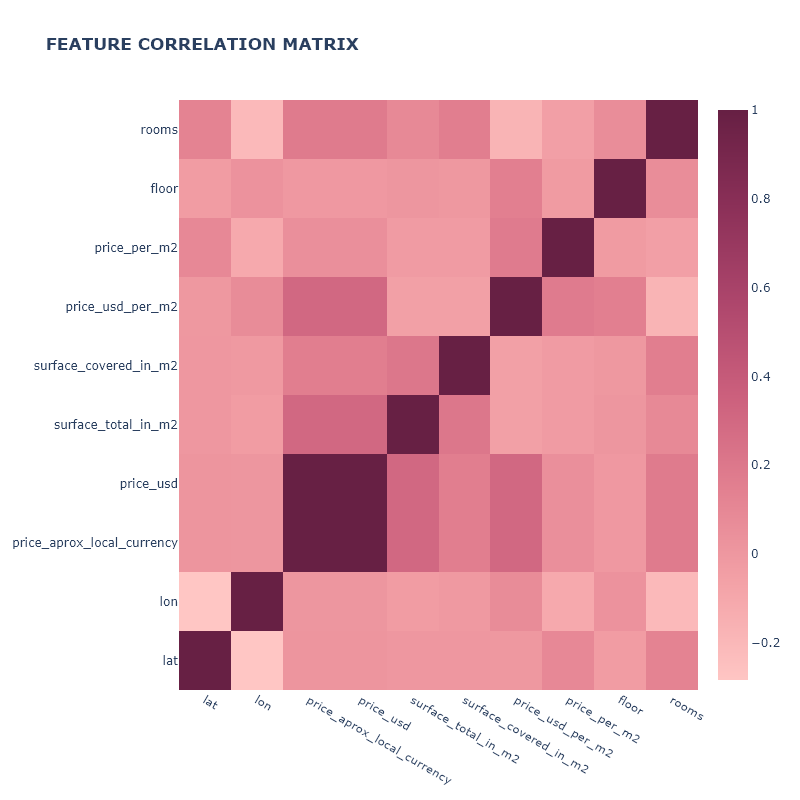

In [371]:
columns = [column for column in df.columns if column != 'bajexp' and column != 'sinexp']

test = df[columns]

correlation_matrix(test, '')

## Eliminacion de outliers <br>

Utilizando el metodo dataframe.describe obtenemos una descripción de medidas de posición de nuestras columnas. De esta se desprenden que las columnas rooms price y expenses cuentan con valores máximos muy elevado en relación al tercer cuartil. De esto inferimos que algunos de los valores son superiores a la sumatoria de la media y tres desviaciones estandar<br>

In [404]:

def outliers_mask(df, col, q):
    df = df[ (df[col] < df[col].quantile(q=1-q)) & (df[col] > df[col].quantile(q=q))]
    return df
    

outliers_mask(df, 'price_usd', 0.05).loc[:, ['price_usd', 'rooms']].describe()


df.loc[:, ['price_usd','rooms']].describe()


,price_usd,rooms
count,88507.000,34840.000
mean,192657.887,3.034
std,133448.113,1.711
min,53335.460,1.000
25%,95000.000,2.000
50%,145000.000,3.000
75%,250000.000,4.000
max,699514.000,32.000


Efectivamente podemos decir que se tratan de outliers debido a su dispersión en relación a la media y su bajo número.

In [ ]:
# Creamos dos mascaras de comprobación
mask_price = df['price_usd'].mean() + df['price_usd'].std()*3
mask_rooms = df['rooms'].mean() + df['rooms'].std()*3
mask_expes = df['expenses'].mean() + df['expenses'].std()*3


# Aplicamos la mascara
df[(df['price_usd'] > mask_price) | (df['rooms'] > mask_rooms) | (df['rooms'] > mask_expes)].loc[:, ['price_usd', 'rooms', 'expenses']].describe()

,price_usd,rooms,expenses
count,1669.000,1151.000,153.000
mean,1792338.923,8.689,11642.072
std,2083341.722,4.968,10889.037
min,8973.380,1.000,1.000
25%,590000.000,5.000,1111.000
50%,1622910.000,9.000,10000.000
75%,2130040.000,11.000,16000.000
max,46545445.000,32.000,53000.000


<br> Filtramos el dataset para excluir los outliers.

In [ ]:
df = df[(df['price_usd'] < mask_price) & (df['rooms'] < mask_rooms) & (df['expenses'] < mask_expes)]